In [1]:
from __future__ import division

import itertools
import os
import re

import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [2]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

In [3]:
DATA_FOLDER = 'data'
NAMESPACE = {'an': 'http://docs.oasis-open.org/legaldocml/ns/akn/3.0/CSD03'}
ALPHANUM_REGEX = re.compile('[\W_+]', re.UNICODE)

In [4]:
def to_tokens(s):
    return set(ALPHANUM_REGEX.sub(' ', s).lower().split())

In [5]:
def jaccard_distance(x, y):    
    return 1 - (len(x['tokens'] & y['tokens']) / len(x['tokens'] | y['tokens']))

In [6]:
amendments = []

for filename in os.listdir(DATA_FOLDER):
    tree = ET.parse(os.path.join(DATA_FOLDER, filename))
    
    _id = tree.find('.//an:FRBRnumber', NAMESPACE).get('value')
    authors = [el.text for el in tree.findall('.//an:docProponent', NAMESPACE)]
    text = ' '.join(tree.find('.//an:amendmentContent', NAMESPACE).itertext())
    tokens = to_tokens(text)
    
    amendments.append({'_id': _id, 'authors': authors, 'tokens': tokens})

In [7]:
distances = [jaccard_distance(x, y) for x, y in itertools.combinations(amendments, 2)]

In [8]:
Z_single = linkage(distances, method='single')

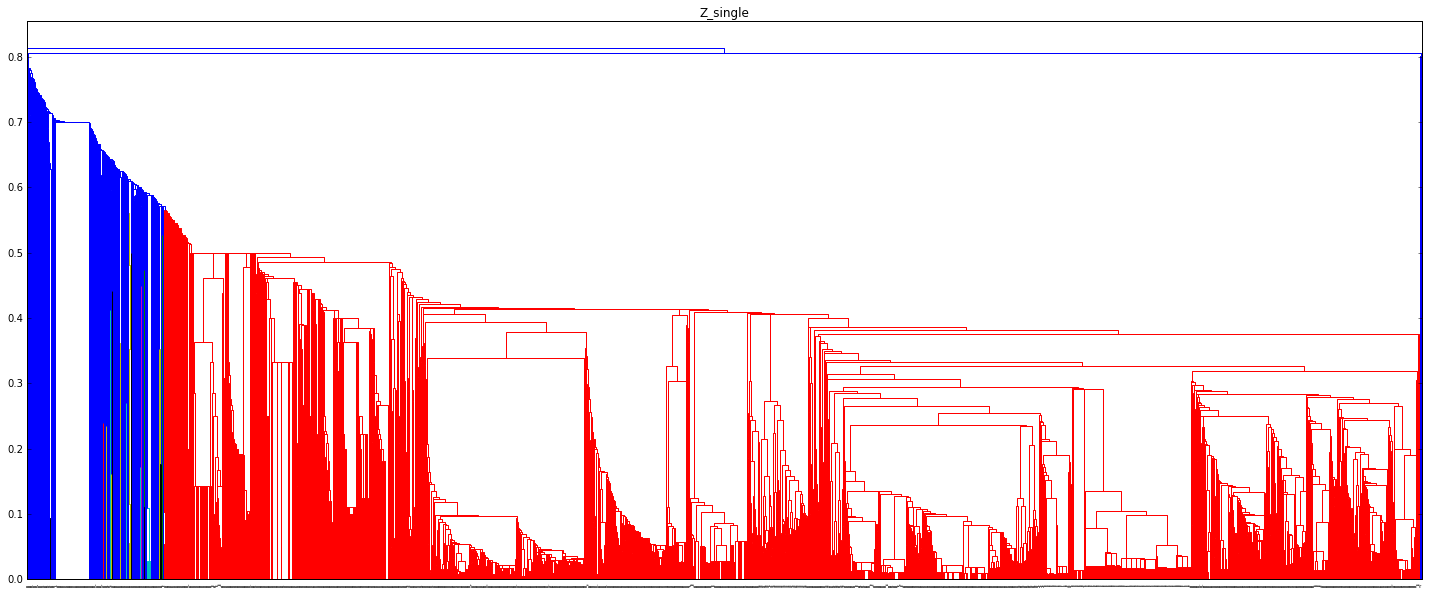

In [9]:
plt.figure(figsize=(25, 10))
plt.title('Z_single')
dendrogram(
    Z_single,
    leaf_rotation=90.,
    leaf_font_size=1.,
)
plt.show()

In [10]:
Z_complete = linkage(distances, method='complete')

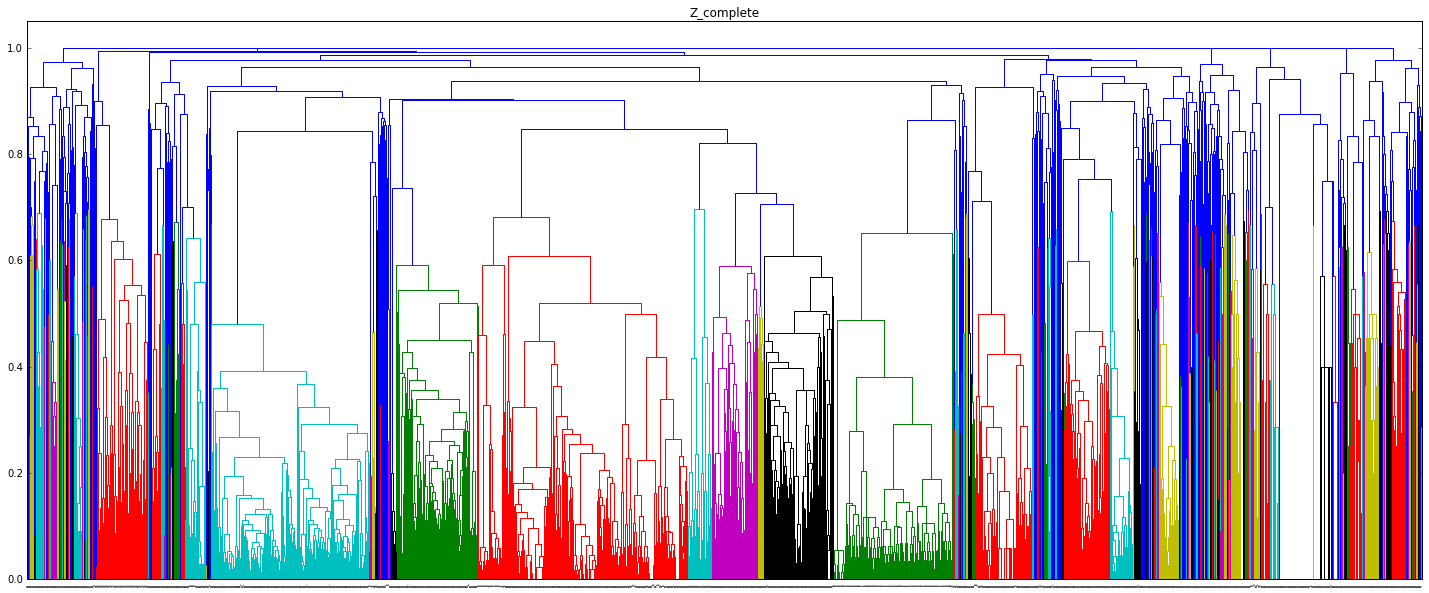

In [11]:
plt.figure(figsize=(25, 10))
plt.title('Z_complete')
dendrogram(
    Z_complete,
    leaf_rotation=90.,
    leaf_font_size=1.,
)
plt.show()

In [12]:
Z_average = linkage(distances, method='average')

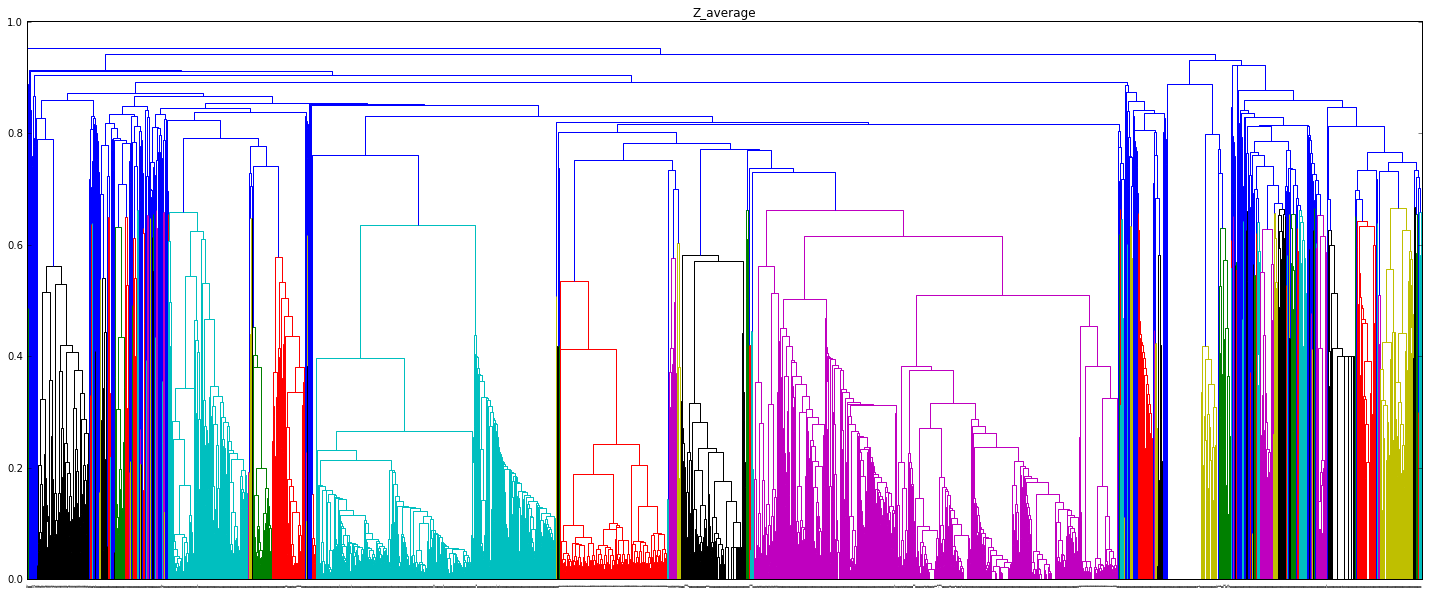

In [13]:
plt.figure(figsize=(25, 10))
plt.title('Z_average')
dendrogram(
    Z_average,
    leaf_rotation=90.,
    leaf_font_size=1.,
)
plt.show()

In [14]:
Z_weighted = linkage(distances, method='weighted')

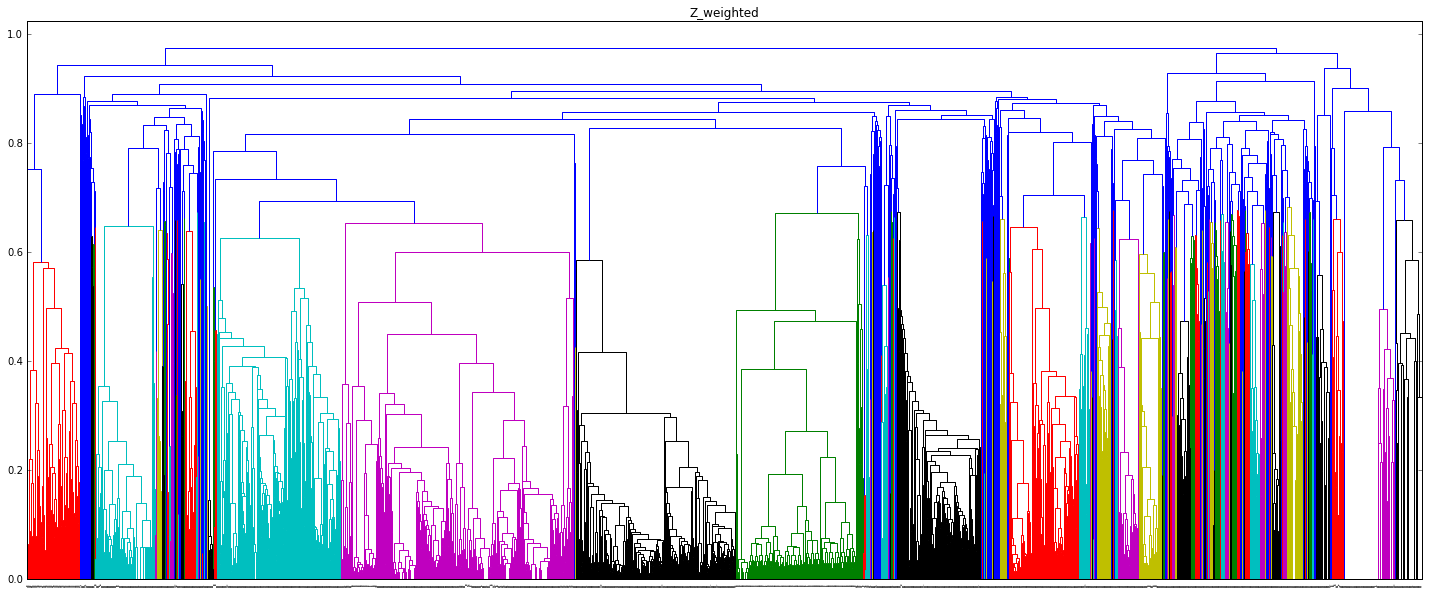

In [15]:
plt.figure(figsize=(25, 10))
plt.title('Z_weighted')
dendrogram(
    Z_weighted,
    leaf_rotation=90.,
    leaf_font_size=1.,
)
plt.show()